# **나이브 베이즈 분류기 (Naive Bayes Classification)**

* 베이즈 정리를 기반으로 하는 확률적 분류 알고리즘
* 모든 특성(feature)이 독립적이라는 베이즈 정리의 기본 가정 하에 작동하며, 텍스트 분류, 스팸 필터링, 감정 분석 등 다양한 분야에서 활용

### 나이브 베이즈 분류기의 종류

1. **가우시안 나이브 베이즈 (Gaussian Naive Bayes)**: 연속적인 데이터에 대해 가우시안(정규) 분포를 가정
2. **베르누이 나이브 베이즈 (Bernoulli Naive Bayes)**: 이진(0/1) 데이터에 적합하며, 텍스트 분류에서 단어의 존재 여부를 기반으로 작동
3. **다항 나이브 베이즈 (Multinomial Naive Bayes)**: 단어의 발생 빈도와 같은 정수형 데이터를 처리하는 데 사용

### 나이브 베이즈의 확률 모델

* 나이브 베이즈는 조건부 확률 모델로, 주어진 특성 벡터 \( x \)에 대해 \( k \)개의 가능한 클래스에 대한 확률을 출력

\begin{equation}
p(C_k|x) = \frac{p(C_k) \cdot p(x|C_k)}{p(x)}
\end{equation}

* 위 식에서 분모는 모든 클래스에 대해 동일하므로 예측에는 영향을 미치지 않는 상수값에 해당
* 따라서, 최종 예측은 다음과 같이 비례식으로 표현 가능

\begin{aligned}
p(C_k|x)&∝p(C_k)p(x|C_k)\\
&∝p(C_k,x_1,...,x_n)
\end{aligned}

* 최종적으로 연쇄 법칙을 사용해 아래와 같은 식으로 표현 가능

\begin{aligned}
p(C_k,x_1,...,x_n)&=p(C_k)p(x_1,...,x_n|C_k)\\
&=p(C_k)p(x_1|C_k)p(x_2,...,x_n|C_k,x_1)\\
&=p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)p(x_3,...,x_n|C_k,x_1,x_2)\\
&=p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)...p(x_n|C_k,x_1,x_2,...,x_n-1)
\end{aligned}

* 위 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과에 해당

\begin{equation}
\hat{y} = \arg\max_k \ p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation}

### 20 Newsgroups 데이터셋
* **데이터셋**: 20 Newsgroups (텍스트 뉴스 기사)
* **문제**: 뉴스 기사를 카테고리별로 분류 (다중 클래스 분류)
* **알고리즘**: Multinomial Naive Bayes, Bernoulli Naive Bayes

### 실습 목표
1. 텍스트 데이터 전처리 (Vectorization)
2. Naive Bayes의 독립성 가정 이해
3. CountVectorizer vs TF-IDF 비교
4. Multinomial vs Bernoulli Naive Bayes 비교

## 1. 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [2]:
# 나이브 베이즈 분류기의 클래스별 사전 확률과 가능도를 사용하여 클래스 가능성 계산

# 각 클래스의 사전 확률 정의 (p(C_k) 부분)
prior = [0.45, 0.3, 0.15, 0.1]

# 각 클래스에 대한 가능도 정의 (p(x|C_k) 부분)
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0.5, 0.35], [0.6, 0.2, 0.2]]

# 클래스 인덱스 초기화
idx = 0

# 각 클래스에 대해 사전 확률과 가능도를 사용하여 가능성 계산
for c, xs in zip(prior, likelihood):
    result = 1.  # 결과 초기화
    
    # 가능도의 각 요소를 곱함
    for x in xs:
        result *= x
    
    # 사전 확률을 곱함
    result *= c
    
    # 클래스 인덱스 증가
    idx += 1

    # 각 클래스의 계산된 가능성 출력
    print(f"{idx}번째 클래스의 가능성: {result}")

1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


## 2. 데이터 로딩

20 Newsgroups 데이터셋에서 일부 카테고리만 선택하여 사용합니다.

In [3]:
# 4개 카테고리 선택 (분류를 쉽게 하기 위해)
categories = [
    'alt.atheism',
    'comp.graphics', 
    'sci.space',
    'talk.politics.guns'
]

# Train 데이터
train_data = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')  # 노이즈 제거
)

# Test 데이터
test_data = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

print(f"\n=== 데이터 정보 ===")
print(f"Train 샘플 수: {len(train_data.data)}")
print(f"Test 샘플 수: {len(test_data.data)}")
print(f"카테고리 수: {len(categories)}")
print(f"\n카테고리: {categories}")


=== 데이터 정보 ===
Train 샘플 수: 2203
Test 샘플 수: 1466
카테고리 수: 4

카테고리: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.guns']


In [4]:
# 샘플 데이터 확인
print("=== 샘플 텍스트 ===")
print(f"카테고리: {train_data.target_names[train_data.target[0]]}")
print(f"\n내용 (처음 500자):\n{train_data.data[0][:500]}")
print("...")

=== 샘플 텍스트 ===
카테고리: alt.atheism

내용 (처음 500자):

Gregg, I'm really sorry if having it pointed out that in practice
things aren't quite the wonderful utopia you folks seem to claim
them to be upsets you, but exactly who is being childish here is 
open to question.

BBCI was an example of an Islamically owned and operated bank -
what will someone bet me they weren't "real" Islamic owners and
operators? - and yet it actually turned out to be a long-running
and quite ruthless operation to steal money from small and often
quite naive depositors.


...


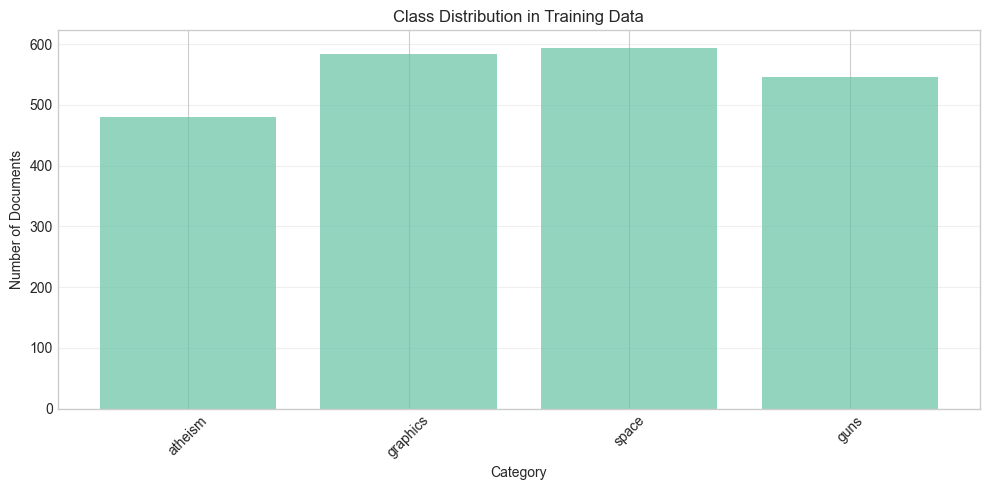

클래스 분포:
alt.atheism: 480개
comp.graphics: 584개
sci.space: 593개
talk.politics.guns: 546개


In [5]:
# 클래스 분포 확인
train_labels, train_counts = np.unique(train_data.target, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(range(len(categories)), train_counts, alpha=0.7)
plt.xticks(range(len(categories)), [cat.split('.')[-1] for cat in categories], rotation=45)
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.title('Class Distribution in Training Data')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("클래스 분포:")
for cat, count in zip(categories, train_counts):
    print(f"{cat}: {count}개")

## 3. 텍스트 Vectorization
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

### 방법 1: CountVectorizer
- 단어의 출현 빈도를 그대로 벡터로 사용

In [6]:
# CountVectorizer
count_vectorizer = CountVectorizer(
    max_features=5000,  # 상위 5000개 단어만 사용
    min_df=2,           # 최소 2개 문서에 출현
    max_df=0.8,         # 80% 이상 문서에 출현하는 단어 제외
    stop_words='english'  # 영어 불용어 제거
)

X_train_count = count_vectorizer.fit_transform(train_data.data)
X_test_count = count_vectorizer.transform(test_data.data)

print("=== CountVectorizer ===")
print(f"Train shape: {X_train_count.shape}")
print(f"Test shape: {X_test_count.shape}")
print(f"Vocabulary size: {len(count_vectorizer.vocabulary_)}")
print(f"\n예시 단어 (처음 20개): {list(count_vectorizer.vocabulary_.keys())[:20]}")

=== CountVectorizer ===
Train shape: (2203, 5000)
Test shape: (1466, 5000)
Vocabulary size: 5000

예시 단어 (처음 20개): ['gregg', 'really', 'sorry', 'having', 'pointed', 'practice', 'things', 'aren', 'quite', 'wonderful', 'folks', 'claim', 'exactly', 'open', 'question', 'example', 'owned', 'operated', 'bank', 'bet']


+ train set에서만 fit_transform을 사용하는 이유
* fit_transform은 데이터의 기존 평균과 분산을 고려하여 이를 0과 1로 scaling해주는 메서드에 해당
* 결론적으로, 이 과정에서 0과 1의 평균과 분산을 갖는 데이터를 학습해 test set에서도 well-performing 하는 모델을 만드는 것이 목표
* 만약 test set에서도 fit_transform을 사용할 경우 모델이 test_set 또한 학습하게 되는 악효과가 발생할 수 있음

In [7]:
# 벡터화된 첫 번째 문서(0)의 단어(*) 빈도(n)를 출력 "(0, *)  n"
for v in X_train_count[0]:
    print(v)

  (0, 2073)	1
  (0, 3723)	1
  (0, 4217)	1
  (0, 2141)	1
  (0, 3412)	1
  (0, 3466)	1
  (0, 4560)	1
  (0, 468)	1
  (0, 3659)	3
  (0, 4937)	1
  (0, 1867)	1
  (0, 948)	1
  (0, 1663)	1
  (0, 3171)	1
  (0, 3651)	1
  (0, 1667)	1
  (0, 3231)	2
  (0, 3174)	2
  (0, 608)	3
  (0, 660)	1
  (0, 4899)	1
  (0, 3719)	1
  (0, 2441)	1
  (0, 3233)	1
  (0, 3180)	1
  (0, 292)	1
  (0, 4680)	1
  (0, 2712)	1
  (0, 3952)	1
  (0, 3176)	1
  (0, 2950)	1
  (0, 4185)	1
  (0, 3012)	2
  (0, 1393)	1
  (0, 2652)	1
  (0, 3987)	1
  (0, 3019)	1
  (0, 2966)	1
  (0, 4901)	1
  (0, 4347)	1
  (0, 646)	1
  (0, 1190)	1
  (0, 3444)	1
  (0, 1474)	1
  (0, 4674)	1
  (0, 4562)	1
  (0, 4945)	1
  (0, 3900)	1
  (0, 4588)	1


### 방법 2: TF-IDF Vectorizer
- 단어의 중요도를 고려 (TF-IDF = Term Frequency × Inverse Document Frequency)
- 흔한 단어는 낮은 가중치, 희귀한 단어는 높은 가중치

In [8]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data.data)
X_test_tfidf = tfidf_vectorizer.transform(test_data.data)

print("=== TF-IDF Vectorizer ===")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

=== TF-IDF Vectorizer ===
Train shape: (2203, 5000)
Test shape: (1466, 5000)
Vocabulary size: 5000


In [10]:
# 벡터화된 첫 번째 문서(0)의 해시(*) 빈도(n - 해시화 과정으로 인해 특정 값에 대한 음 양의 값을 가짐)를 출력 "(0, *)  n"

for v in X_train_tfidf[0]:
    print(v)

  (0, 4588)	0.06564113627802265
  (0, 3900)	0.07436331177681353
  (0, 4945)	0.080147072237358
  (0, 4562)	0.11360327025011308
  (0, 4674)	0.08602961426205678
  (0, 1474)	0.056875868011850024
  (0, 3444)	0.11151981412232219
  (0, 1190)	0.107014710715201
  (0, 646)	0.124586560810133
  (0, 4347)	0.11650616632437273
  (0, 4901)	0.13059528621156455
  (0, 2966)	0.1422943295529078
  (0, 3019)	0.1464698988582776
  (0, 3987)	0.16234451150499066
  (0, 2652)	0.08936994675753063
  (0, 1393)	0.07832365141240627
  (0, 3012)	0.30316076532941755
  (0, 4185)	0.09218604352512574
  (0, 2950)	0.09800293902469365
  (0, 3176)	0.1220856540621041
  (0, 3952)	0.10784761068259284
  (0, 2712)	0.07915655137979812
  (0, 4680)	0.124586560810133
  (0, 292)	0.0817181263088442
  (0, 3180)	0.1488828890878199
  (0, 3233)	0.124586560810133
  (0, 2441)	0.1220856540621041
  (0, 3719)	0.08586660841420075
  (0, 4899)	0.1220856540621041
  (0, 660)	0.12947788289682613
  (0, 608)	0.3953100503328481
  (0, 3174)	0.288574167362378

In [12]:
# Count vs TF-IDF 비교 (첫 번째 문서)
doc_idx = 0
count_values = X_train_count[doc_idx].toarray()[0]
tfidf_values = X_train_tfidf[doc_idx].toarray()[0]

# 값이 있는 단어만 추출
nonzero_indices = np.where(count_values > 0)[0]

print(f"=== 문서 {doc_idx}의 상위 10개 단어 ===")
print(f"카테고리: {train_data.target_names[train_data.target[doc_idx]]}\n")

# 단어, Count, TF-IDF 값 출력
word_comparison = []
for idx in nonzero_indices[:10]:
    word = [w for w, i in count_vectorizer.vocabulary_.items() if i == idx][0]
    word_comparison.append({
        'word': word,
        'count': count_values[idx],
        'tfidf': tfidf_values[idx]
    })

df_comparison = pd.DataFrame(word_comparison)
print(df_comparison)

=== 문서 0의 상위 10개 단어 ===
카테고리: alt.atheism

       word  count     tfidf
0  actually      1  0.081718
1      aren      1  0.102568
2      bank      3  0.395310
3  believed      1  0.124587
4       bet      1  0.129478
5     claim      1  0.096404
6    couldn      1  0.107015
7       did      1  0.078324
8       don      1  0.056876
9   exactly      1  0.096925


## 4. Multinomial Naive Bayes

### 이론:
- **가정**: 각 단어의 출현은 서로 독립적
- **적용**: 단어 빈도(count)를 사용한 분류
- **확률 계산**: $P(class|document) \propto P(class) \times \prod P(word|class)$

In [13]:
# Multinomial NB with CountVectorizer
mnb_count = MultinomialNB(alpha=1.0)  # alpha: Laplace smoothing
mnb_count.fit(X_train_count, train_data.target)

y_pred_mnb_count = mnb_count.predict(X_test_count)
acc_mnb_count = accuracy_score(test_data.target, y_pred_mnb_count)

print("=== Multinomial NB + CountVectorizer ===")
print(f"Test Accuracy: {acc_mnb_count:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_data.target, y_pred_mnb_count, 
                            target_names=train_data.target_names))

=== Multinomial NB + CountVectorizer ===
Test Accuracy: 0.8499

Classification Report:
                    precision    recall  f1-score   support

       alt.atheism       0.76      0.83      0.80       319
     comp.graphics       0.92      0.90      0.91       389
         sci.space       0.85      0.84      0.84       394
talk.politics.guns       0.87      0.82      0.85       364

          accuracy                           0.85      1466
         macro avg       0.85      0.85      0.85      1466
      weighted avg       0.85      0.85      0.85      1466



In [14]:
# Multinomial NB with TF-IDF
mnb_tfidf = MultinomialNB(alpha=1.0)
mnb_tfidf.fit(X_train_tfidf, train_data.target)

y_pred_mnb_tfidf = mnb_tfidf.predict(X_test_tfidf)
acc_mnb_tfidf = accuracy_score(test_data.target, y_pred_mnb_tfidf)

print("=== Multinomial NB + TF-IDF ===")
print(f"Test Accuracy: {acc_mnb_tfidf:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_data.target, y_pred_mnb_tfidf, 
                            target_names=train_data.target_names))

=== Multinomial NB + TF-IDF ===
Test Accuracy: 0.8513

Classification Report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.74      0.80       319
     comp.graphics       0.88      0.93      0.90       389
         sci.space       0.81      0.85      0.83       394
talk.politics.guns       0.85      0.87      0.86       364

          accuracy                           0.85      1466
         macro avg       0.85      0.85      0.85      1466
      weighted avg       0.85      0.85      0.85      1466



## 5. Bernoulli Naive Bayes

### 이론:
- **가정**: 각 단어의 존재 여부만 고려 (binary)
- **적용**: 단어가 있으면 1, 없으면 0
- **특징**: 짧은 문서나 이진 특성에 효과적

In [15]:
# Bernoulli NB with CountVectorizer (binary=True)
bnb_count = BernoulliNB(alpha=1.0)
bnb_count.fit(X_train_count, train_data.target)

y_pred_bnb_count = bnb_count.predict(X_test_count)
acc_bnb_count = accuracy_score(test_data.target, y_pred_bnb_count)

print("=== Bernoulli NB + CountVectorizer ===")
print(f"Test Accuracy: {acc_bnb_count:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_data.target, y_pred_bnb_count, 
                            target_names=train_data.target_names))

=== Bernoulli NB + CountVectorizer ===
Test Accuracy: 0.6917

Classification Report:
                    precision    recall  f1-score   support

       alt.atheism       0.71      0.73      0.72       319
     comp.graphics       0.54      0.93      0.68       389
         sci.space       0.90      0.52      0.66       394
talk.politics.guns       0.91      0.59      0.71       364

          accuracy                           0.69      1466
         macro avg       0.76      0.69      0.69      1466
      weighted avg       0.76      0.69      0.69      1466



## 6. 성능 비교

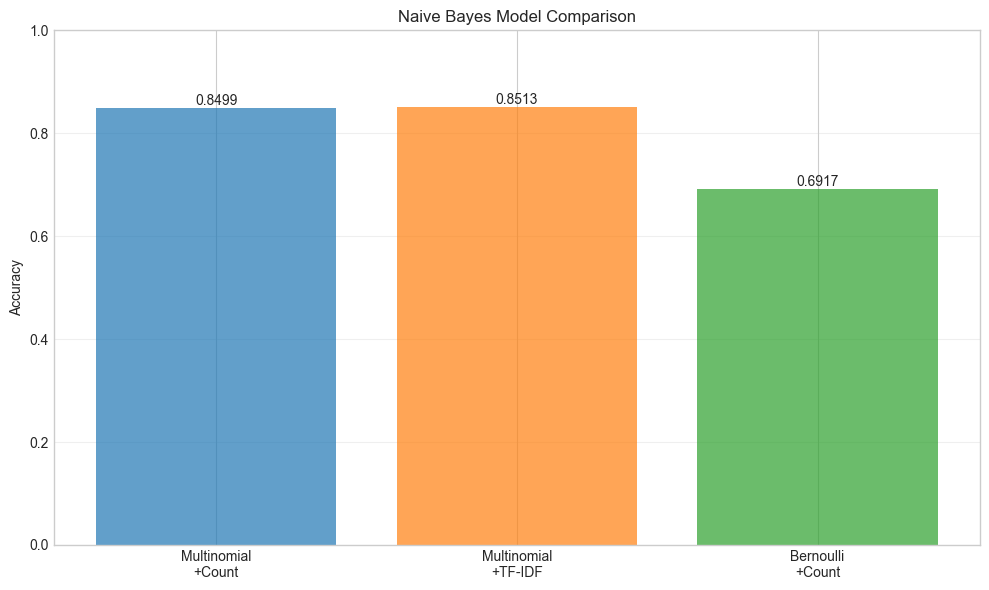


=== 모델 성능 순위 ===
1. Multinomial +TF-IDF: 0.8513
2. Multinomial +Count: 0.8499
3. Bernoulli +Count: 0.6917


In [17]:
# 성능 비교 시각화
models = ['Multinomial\n+Count', 'Multinomial\n+TF-IDF', 'Bernoulli\n+Count']
accuracies = [acc_mnb_count, acc_mnb_tfidf, acc_bnb_count]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Accuracy')
plt.title('Naive Bayes Model Comparison')
plt.ylim([0.0, 1.0])
plt.grid(axis='y', alpha=0.3)

# 막대 위에 값 표시
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== 모델 성능 순위 ===")
results = list(zip(models, accuracies))
results.sort(key=lambda x: x[1], reverse=True)
for i, (model, acc) in enumerate(results, 1):
    print(f"{i}. {model.replace(chr(10), ' ')}: {acc:.4f}")

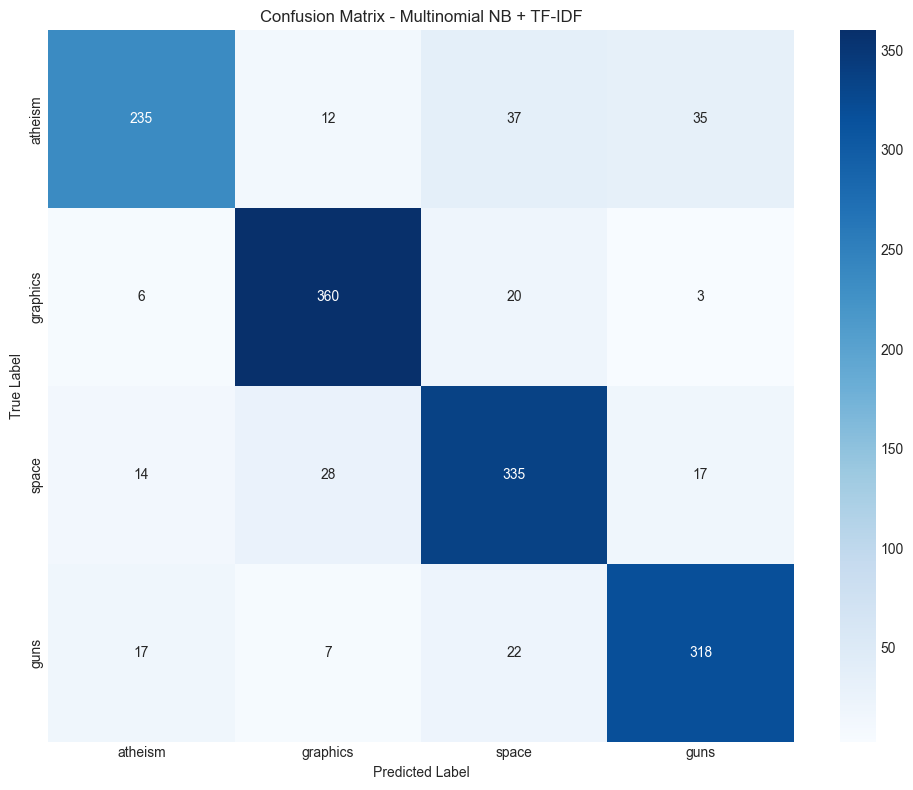

In [18]:
# Confusion Matrix - 최고 성능 모델
best_predictions = y_pred_mnb_tfidf if acc_mnb_tfidf >= acc_mnb_count else y_pred_mnb_count
best_model_name = "Multinomial NB + TF-IDF" if acc_mnb_tfidf >= acc_mnb_count else "Multinomial NB + Count"

cm = confusion_matrix(test_data.target, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[cat.split('.')[-1] for cat in categories],
            yticklabels=[cat.split('.')[-1] for cat in categories])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 7. Feature Importance (단어 중요도)

각 카테고리별로 가장 중요한 단어를 확인합니다.

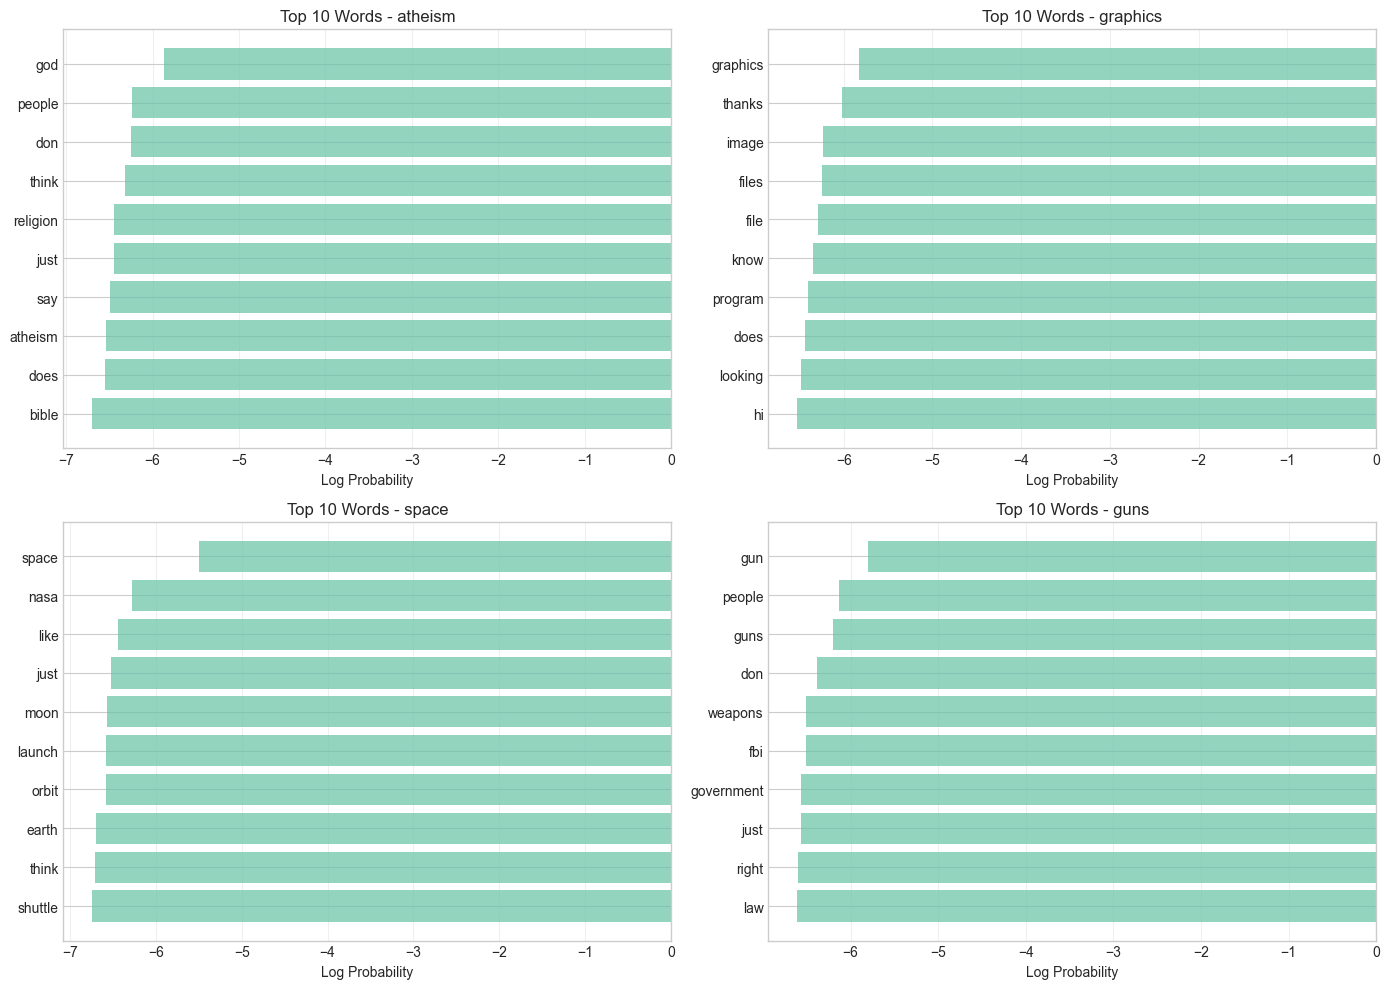


=== 카테고리별 핵심 단어 ===
alt.atheism: religion, think, don, people, god
comp.graphics: file, files, image, thanks, graphics
sci.space: moon, just, like, nasa, space
talk.politics.guns: weapons, don, guns, people, gun


In [19]:
# Multinomial NB (TF-IDF) 모델의 feature importance
feature_names = tfidf_vectorizer.get_feature_names_out()

# 각 클래스별 상위 10개 단어
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, category in enumerate(categories):
    # 해당 클래스의 log probability
    top_indices = np.argsort(mnb_tfidf.feature_log_prob_[i])[-10:]
    top_words = [feature_names[idx] for idx in top_indices]
    top_probs = mnb_tfidf.feature_log_prob_[i][top_indices]
    
    axes[i].barh(range(10), top_probs, alpha=0.7)
    axes[i].set_yticks(range(10))
    axes[i].set_yticklabels(top_words)
    axes[i].set_xlabel('Log Probability')
    axes[i].set_title(f'Top 10 Words - {category.split(".")[-1]}')
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 카테고리별 핵심 단어 ===")
for i, category in enumerate(categories):
    top_indices = np.argsort(mnb_tfidf.feature_log_prob_[i])[-5:]
    top_words = [feature_names[idx] for idx in top_indices]
    print(f"{category}: {', '.join(top_words)}")

## 8. 실시간 예측 테스트

In [20]:
def predict_category(text, model, vectorizer, target_names):
    """텍스트를 입력받아 카테고리 예측"""
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)[0]
    probabilities = model.predict_proba(text_vectorized)[0]
    
    print(f"예측 카테고리: {target_names[prediction]}")
    print(f"\n확률 분포:")
    for i, prob in enumerate(probabilities):
        print(f"  {target_names[i]}: {prob:.4f}")
    
    return prediction

# 테스트 예시
test_texts = [
    "I believe in science and evidence-based reasoning, not religious dogma.",
    "The graphics rendering engine uses advanced GPU acceleration techniques.",
    "NASA announced a new mission to Mars with the latest rover technology.",
    "The Second Amendment protects the right to bear arms for self-defense."
]

print("=== 실시간 예측 테스트 ===")
for i, text in enumerate(test_texts, 1):
    print(f"\n[테스트 {i}]")
    print(f"입력 텍스트: {text}")
    print("-" * 70)
    predict_category(text, mnb_tfidf, tfidf_vectorizer, train_data.target_names)
    print()

=== 실시간 예측 테스트 ===

[테스트 1]
입력 텍스트: I believe in science and evidence-based reasoning, not religious dogma.
----------------------------------------------------------------------
예측 카테고리: alt.atheism

확률 분포:
  alt.atheism: 0.7166
  comp.graphics: 0.0462
  sci.space: 0.1073
  talk.politics.guns: 0.1299


[테스트 2]
입력 텍스트: The graphics rendering engine uses advanced GPU acceleration techniques.
----------------------------------------------------------------------
예측 카테고리: comp.graphics

확률 분포:
  alt.atheism: 0.1082
  comp.graphics: 0.5185
  sci.space: 0.2721
  talk.politics.guns: 0.1012


[테스트 3]
입력 텍스트: NASA announced a new mission to Mars with the latest rover technology.
----------------------------------------------------------------------
예측 카테고리: sci.space

확률 분포:
  alt.atheism: 0.0565
  comp.graphics: 0.0970
  sci.space: 0.7811
  talk.politics.guns: 0.0654


[테스트 4]
입력 텍스트: The Second Amendment protects the right to bear arms for self-defense.
--------------------------------------

## 9. Cross-Validation

=== Cross-Validation Results ===

Multinomial NB (TF-IDF):
  Scores: [0.90249433 0.85714286 0.89115646 0.89545455 0.87045455]
  Mean: 0.8833 (+/- 0.0169)

Bernoulli NB (Count):
  Scores: [0.7414966  0.77097506 0.7324263  0.74545455 0.74545455]
  Mean: 0.7472 (+/- 0.0128)


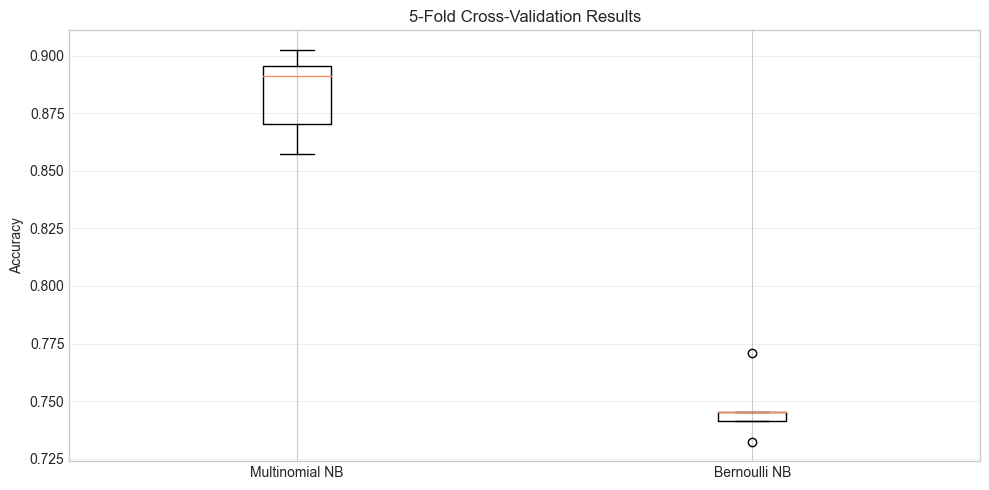

In [21]:
# 5-fold Cross Validation
cv_scores_mnb = cross_val_score(mnb_tfidf, X_train_tfidf, train_data.target, cv=5, scoring='accuracy')
cv_scores_bnb = cross_val_score(bnb_count, X_train_count, train_data.target, cv=5, scoring='accuracy')

print("=== Cross-Validation Results ===")
print(f"\nMultinomial NB (TF-IDF):")
print(f"  Scores: {cv_scores_mnb}")
print(f"  Mean: {cv_scores_mnb.mean():.4f} (+/- {cv_scores_mnb.std():.4f})")

print(f"\nBernoulli NB (Count):")
print(f"  Scores: {cv_scores_bnb}")
print(f"  Mean: {cv_scores_bnb.mean():.4f} (+/- {cv_scores_bnb.std():.4f})")

# 시각화
plt.figure(figsize=(10, 5))
plt.boxplot([cv_scores_mnb, cv_scores_bnb], labels=['Multinomial NB', 'Bernoulli NB'])
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. 결론 및 요약

### 주요 발견사항:
1. **TF-IDF가 Count보다 우수**: 단어의 중요도를 고려하는 것이 효과적
2. **Multinomial NB가 Bernoulli NB보다 우수**: 단어 빈도 정보가 유용
3. **독립성 가정의 실용성**: 단어 간 독립성 가정이 완벽하지 않지만 텍스트 분류에서 잘 작동
4. **빠른 학습 속도**: Naive Bayes는 계산이 간단하여 대용량 텍스트 데이터에 적합

### Naive Bayes 사용 시기:
- ✅ 텍스트 분류 (스팸 필터, 감정 분석, 뉴스 분류)
- ✅ 대용량 데이터 (빠른 학습 필요)
- ✅ 고차원 데이터 (특성 수가 매우 많은 경우)
- ❌ Feature 간 강한 상관관계 (독립성 가정 위배)
- ❌ 복잡한 비선형 패턴

### 실무 적용:
- 이메일 스팸 필터링
- 고객 리뷰 감정 분석
- 문서 자동 분류 시스템
- 실시간 텍스트 분류 (빠른 예측 속도)